In [1]:
using DifferentialEquations
using ParameterizedFunctions
using Dierckx
using Parameters
using Distributions
using Turing
using ForwardDiff
using DataFrames, CSV, Random, PyPlot, PyCall, Revise
using KernelDensity: kde
@pyimport numpy as np
@pyimport scienceplots

In [2]:
@with_kw struct ShipData{Tt,Tu,Tv,Tr,Tx,Ty,Tψ,Tδ,Tn_p}
    time::Tt
    u::Tu
    v::Tv
    r::Tr
    x::Tx
    y::Ty
    ψ::Tψ
    δ::Tδ
    n_p::Tn_p
end

@with_kw mutable struct Mmg3DofBasicParams{T}
    L_pp::T
    B::T
    d::T
    x_G::T
    D_p::T
    m::T
    I_zG::T
    A_R::T
    η::T
    m_x::T
    m_y::T
    J_z::T
    f_α::T
    ϵ::T
    t_R::T
    x_R::T
    a_H::T
    x_H::T
    γ_R_minus::T
    γ_R_plus::T
    l_R::T
    κ::T
    t_P::T
    w_P0::T
    x_P::T
end

@with_kw mutable struct Mmg3DofManeuveringParams{T}
    k_0::T
    k_1::T
    k_2::T
    R_0_dash::T
    X_vv_dash::T
    X_vr_dash::T
    X_rr_dash::T
    X_vvvv_dash::T
    Y_v_dash::T
    Y_r_dash::T
    Y_vvv_dash::T
    Y_vvr_dash::T
    Y_vrr_dash::T
    Y_rrr_dash::T
    N_v_dash::T
    N_r_dash::T
    N_vvv_dash::T
    N_vvr_dash::T
    N_vrr_dash::T
    N_rrr_dash::T
end

Mmg3DofManeuveringParams

In [3]:
function calc_position(time_vec, u_vec, v_vec, r_vec; x0=0.0, y0=0.0, ψ0=0.0)
    dim = length(time_vec)
    x_vec = zeros(Float64, dim)
    y_vec = zeros(Float64, dim)
    ψ_vec = zeros(Float64, dim)
    x_vec[1] = x0
    y_vec[1] = y0
    ψ_vec[1] = ψ0
    for i in 2:dim
        Δt = time_vec[i] - time_vec[i-1]
        ψ_vec[i] = ψ_vec[i-1] + r_vec[i] * Δt
        x_vec[i] =
            x_vec[i-1] + (u_vec[i] * cos(ψ_vec[i]) - v_vec[i] * sin(ψ_vec[i])) * Δt
        y_vec[i] =
            y_vec[i-1] + (u_vec[i] * sin(ψ_vec[i]) + v_vec[i] * cos(ψ_vec[i])) * Δt
    end
    x_vec, y_vec, ψ_vec
end

function get_KVLCC2_L7_basic_params(ρ=1025.0)
    L_pp = 7.00  # 船長Lpp[m]
    B = 1.27  # 船幅[m]
    d = 0.46  # 喫水[m]
    nabla = 3.27  # 排水量[m^3]
    x_G = 0.25  # 重心位置[m]
    # C_b = 0.810  # 方形係数[-]
    D_p = 0.216  # プロペラ直径[m]
    H_R = 0.345  # 舵高さ[m]
    A_R = 0.0539  # 舵断面積[m^2]
    t_P = 0.220  # 推力減少率
    w_P0 = 0.40  # 有効伴流率
    m_x_dash = 0.022  # 付加質量x(無次元)
    m_y_dash = 0.223  # 付加質量y(無次元)
    J_z_dash = 0.011  # 付加質量Izz(無次元)
    t_R = 0.387  # 操縦抵抗減少率
    x_R_dash = -0.500  # 舵の相対位置
    a_H = 0.312  # 舵力増加係数
    x_H_dash = -0.464  # 舵力増分作用位置
    γ_R_minus = 0.395  # 整流係数
    γ_R_plus = 0.640  # 整流係数
    l_r_dash = -0.710  # 船長に対する舵位置
    x_P_dash = -0.690  # 船長に対するプロペラ位置
    ϵ = 1.09  # プロペラ・舵位置伴流係数比
    κ = 0.50  # 修正係数
    f_α = 2.747  # 直圧力勾配係数

    L_pp = L_pp  # 船長Lpp[m]
    B = B  # 船幅[m]
    d = d  # 喫水[m]
    x_G = x_G  # 重心位置[]
    D_p = D_p  # プロペラ直径[m]
    m = ρ * nabla  # 質量(無次元化)[kg]
    I_zG = ρ * nabla * ((0.25 * L_pp)^2)  # 慣性モーメント[-]
    A_R = A_R  # 船の断面に対する舵面積比[-]
    η = D_p / H_R  # プロペラ直径に対する舵高さ(Dp/H)
    m_x = (0.5 * ρ * (L_pp^2) * d) * m_x_dash  # 付加質量x(無次元)
    m_y = (0.5 * ρ * (L_pp^2) * d) * m_y_dash  # 付加質量y(無次元)
    J_z = (0.5 * ρ * (L_pp^4) * d) * J_z_dash  # 付加質量Izz(無次元)
    f_α = f_α # 直圧力勾配係数
    ϵ = ϵ  # プロペラ・舵位置伴流係数比
    t_R = t_R  # 操縦抵抗減少率
    x_R = x_R_dash * L_pp  # 舵の位置
    a_H = a_H  # 舵力増加係数
    x_H = x_H_dash * L_pp  # 舵力増分作用位置
    γ_R_minus = γ_R_minus  # 整流係数
    γ_R_plus = γ_R_plus  # 整流係数
    l_R = l_r_dash  # 船長に対する舵位置
    κ = κ  # 修正係数
    t_P = t_P  # 推力減少率
    w_P0 = w_P0  # 有効伴流率
    x_P = x_P_dash  # 船長に対するプロペラ位置
    basic_params = Mmg3DofBasicParams(
        L_pp,
        B,
        d,
        x_G,
        D_p,
        m,
        I_zG,
        A_R,
        η,
        m_x,
        m_y,
        J_z,
        f_α,
        ϵ,
        t_R,
        x_R,
        a_H,
        x_H,
        γ_R_minus,
        γ_R_plus,
        l_R,
        κ,
        t_P,
        w_P0,
        x_P,
    )
    basic_params
end

function get_KVLCC2_L7_maneuvering_params()
    k_0 = 0.2931
    k_1 = -0.2753
    k_2 = -0.1385
    R_0_dash = 0.022
    X_vv_dash = -0.040
    X_vr_dash = 0.002
    X_rr_dash = 0.011
    X_vvvv_dash = 0.771
    Y_v_dash = -0.315
    Y_r_dash = 0.083
    Y_vvv_dash = -1.607
    Y_vvr_dash = 0.379
    Y_vrr_dash = -0.391
    Y_rrr_dash = 0.008
    N_v_dash = -0.137
    N_r_dash = -0.049
    N_vvv_dash = -0.030
    N_vvr_dash = -0.294
    N_vrr_dash = 0.055
    N_rrr_dash = -0.013
    maneuvering_params = Mmg3DofManeuveringParams(
        k_0,
        k_1,
        k_2,
        R_0_dash,
        X_vv_dash,
        X_vr_dash,
        X_rr_dash,
        X_vvvv_dash,
        Y_v_dash,
        Y_r_dash,
        Y_vvv_dash,
        Y_vvr_dash,
        Y_vrr_dash,
        Y_rrr_dash,
        N_v_dash,
        N_r_dash,
        N_vvv_dash,
        N_vvr_dash,
        N_vrr_dash,
        N_rrr_dash,
    )
    maneuvering_params
end

get_KVLCC2_L7_maneuvering_params (generic function with 1 method)

In [4]:
function mmg_3dof_model!(dX, X, p, t)
    u, v, r, x, y, Ψ, δ, n_p = X
    ρ,
    L_pp,
    B,
    d,
    x_G,
    D_p,
    m,
    I_zG,
    A_R,
    η,
    m_x,
    m_y,
    J_z,
    f_α,
    ϵ,
    t_R,
    x_R,
    a_H,
    x_H,
    γ_R_minus,
    γ_R_plus,
    l_R,
    κ,
    t_P,
    w_P0,
    x_P,
    k_0,
    k_1,
    k_2,
    R_0_dash,
    X_vv_dash,
    X_vr_dash,
    X_rr_dash,
    X_vvvv_dash,
    Y_v_dash,
    Y_r_dash,
    Y_vvv_dash,
    Y_vvr_dash,
    Y_vrr_dash,
    Y_rrr_dash,
    N_v_dash,
    N_r_dash,
    N_vvv_dash,
    N_vvr_dash,
    N_vrr_dash,
    N_rrr_dash,
    spl_δ,
    spl_n_p = p

    U = sqrt(u^2 + (v - r * x_G)^2)

    β = 0.0
    if U == 0.0
        β = 0.0
    else
        β = asin(-(v - r * x_G) / U)
    end

    v_dash = 0.0
    if U == 0.0
        v_dash = 0.0
    else
        v_dash = v / U
    end

    r_dash = 0.0
    if U == 0.0
        r_dash = 0.0
    else
        r_dash = r * L_pp / U
    end

    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)

    J = 0.0
    if n_p == 0.0
        J = 0.0
    else
        J = (1 - w_P) * u / (n_p * D_p)
    end
    K_T = k_0 + k_1 * J + k_2 * J^2
    β_R = β - l_R * r_dash
    γ_R = γ_R_minus

    if β_R < 0.0
        γ_R = γ_R_minus
    else
        γ_R = γ_R_plus
    end

    v_R = U * γ_R * β_R

    u_R = 0.0
    if J == 0.0
        u_R = sqrt(η * (κ * ϵ * 8.0 * k_0 * n_p^2 * D_p^4 / pi)^2)
    else
        u_R =
            u *
            (1.0 - w_P) *
            ϵ *
            sqrt(η * (1.0 + κ * (sqrt(1.0 + 8.0 * K_T / (pi * J^2)) - 1))^2 + (1 - η))
    end

    U_R = sqrt(u_R^2 + v_R^2)
    α_R = δ - atan(v_R, u_R)
    F_N = 0.5 * A_R * ρ * f_α * (U_R^2) * sin(α_R)

    X_H = (
        0.5 *
        ρ *
        L_pp *
        d *
        (U^2) *
        (
            -R_0_dash +
            X_vv_dash * (v_dash^2) +
            X_vr_dash * v_dash * r_dash +
            X_rr_dash * (r_dash^2) +
            X_vvvv_dash * (v_dash^4)
        )
    )
    X_R = -(1.0 - t_R) * F_N * sin(δ)
    X_P = (1.0 - t_P) * ρ * K_T * n_p^2 * D_p^4
    Y_H = (
        0.5 *
        ρ *
        L_pp *
        d *
        (U^2) *
        (
            Y_v_dash * v_dash +
            Y_r_dash * r_dash +
            Y_vvv_dash * (v_dash^3) +
            Y_vvr_dash * (v_dash^2) * r_dash +
            Y_vrr_dash * v_dash * (r_dash^2) +
            Y_rrr_dash * (r_dash^3)
        )
    )
    Y_R = -(1 + a_H) * F_N * cos(δ)
    N_H = (
        0.5 *
        ρ *
        (L_pp^2) *
        d *
        (U^2) *
        (
            N_v_dash * v_dash +
            N_r_dash * r_dash +
            N_vvv_dash * (v_dash^3) +
            N_vvr_dash * (v_dash^2) * r_dash +
            N_vrr_dash * v_dash * (r_dash^2) +
            N_rrr_dash * (r_dash^3)
        )
    )
    N_R = -(x_R + a_H * x_H) * F_N * cos(δ)
    dX[1] = du = ((X_H + X_R + X_P) + (m + m_y) * v * r) / (m + m_x)
    dX[2] = dv = ((Y_H + Y_R) - (m + m_x) * u * r) / (m + m_y)
    dX[3] = dr = (N_H + N_R) / (I_zG + J_z) 
    dX[4] = dx = u * cos(Ψ) - v * sin(Ψ)
    dX[5] = dy = u * sin(Ψ) + v * cos(Ψ)
    dX[6] = dΨ = r
    dX[7] = dδ = derivative(spl_δ, t)
    dX[8] = dn_p = derivative(spl_n_p, t)
end

function mmg_3dof_simulate(
    basic_params::Mmg3DofBasicParams,
    maneuvering_params::Mmg3DofManeuveringParams,
    time_list,
    δ_list,
    n_p_list;
    u0=1.4,
    v0=0.0,
    r0=0.0,
    x0=0.0,
    y0=0.0,
    Ψ0=0.0,
    ρ=1025.0,
    algorithm=Tsit5(),
    reltol=1e-8,
    abstol=1e-8
)
    @unpack L_pp,
    B,
    d,
    x_G,
    D_p,
    m,
    I_zG,
    A_R,
    η,
    m_x,
    m_y,
    J_z,
    f_α,
    ϵ,
    t_R,
    x_R,
    a_H,
    x_H,
    γ_R_minus,
    γ_R_plus,
    l_R,
    κ,
    t_P,
    w_P0,
    x_P = basic_params

    @unpack k_0,
    k_1,
    k_2,
    R_0_dash,
    X_vv_dash,
    X_vr_dash,
    X_rr_dash,
    X_vvvv_dash,
    Y_v_dash,
    Y_r_dash,
    Y_vvv_dash,
    Y_vvr_dash,
    Y_vrr_dash,
    Y_rrr_dash,
    N_v_dash,
    N_r_dash,
    N_vvv_dash,
    N_vvr_dash,
    N_vrr_dash,
    N_rrr_dash = maneuvering_params
    simulate(
        L_pp,
        B,
        d,
        x_G,
        D_p,
        m,
        I_zG,
        A_R,
        η,
        m_x,
        m_y,
        J_z,
        f_α,
        ϵ,
        t_R,
        x_R,
        a_H,
        x_H,
        γ_R_minus,
        γ_R_plus,
        l_R,
        κ,
        t_P,
        w_P0,
        x_P,
        k_0,
        k_1,
        k_2,
        R_0_dash,
        X_vv_dash,
        X_vr_dash,
        X_rr_dash,
        X_vvvv_dash,
        Y_v_dash,
        Y_r_dash,
        Y_vvv_dash,
        Y_vvr_dash,
        Y_vrr_dash,
        Y_rrr_dash,
        N_v_dash,
        N_r_dash,
        N_vvv_dash,
        N_vvr_dash,
        N_vrr_dash,
        N_rrr_dash,
        time_list,
        δ_list,
        n_p_list,
        u0=u0,
        v0=v0,
        r0=r0,
        x0=x0,
        y0=y0,
        Ψ0=Ψ0,
        ρ=ρ,
        algorithm=algorithm,
        reltol=reltol,
        abstol=abstol,
    )
end

function simulate(
    L_pp,
    B,
    d,
    x_G,
    D_p,
    m,
    I_zG,
    A_R,
    η,
    m_x,
    m_y,
    J_z,
    f_α,
    ϵ,
    t_R,
    x_R,
    a_H,
    x_H,
    γ_R_minus,
    γ_R_plus,
    l_R,
    κ,
    t_P,
    w_P0,
    x_P,
    k_0,
    k_1,
    k_2,
    R_0_dash,
    X_vv_dash,
    X_vr_dash,
    X_rr_dash,
    X_vvvv_dash,
    Y_v_dash,
    Y_r_dash,
    Y_vvv_dash,
    Y_vvr_dash,
    Y_vrr_dash,
    Y_rrr_dash,
    N_v_dash,
    N_r_dash,
    N_vvv_dash,
    N_vvr_dash,
    N_vrr_dash,
    N_rrr_dash,
    time_list,
    δ_list,
    n_p_list;
    u0=1.4,
    v0=0.0,
    r0=0.0,
    x0=0.0,
    y0=0.0,
    Ψ0=0.0,
    ρ=1025.0,
    algorithm=Tsit5(),
    reltol=1e-8,
    abstol=1e-8,
)
    spl_δ = Spline1D(time_list, δ_list)
    spl_n_p = Spline1D(time_list, n_p_list)

    X0 = [u0; v0; r0; x0; y0; Ψ0; δ_list[1]; n_p_list[1]]
    p = (
        ρ,
        L_pp,
        B,
        d,
        x_G,
        D_p,
        m,
        I_zG,
        A_R,
        η,
        m_x,
        m_y,
        J_z,
        f_α,
        ϵ,
        t_R,
        x_R,
        a_H,
        x_H,
        γ_R_minus,
        γ_R_plus,
        l_R,
        κ,
        t_P,
        w_P0,
        x_P,
        k_0,
        k_1,
        k_2,
        R_0_dash,
        X_vv_dash,
        X_vr_dash,
        X_rr_dash,
        X_vvvv_dash,
        Y_v_dash,
        Y_r_dash,
        Y_vvv_dash,
        Y_vvr_dash,
        Y_vrr_dash,
        Y_rrr_dash,
        N_v_dash,
        N_r_dash,
        N_vvv_dash,
        N_vvr_dash,
        N_vrr_dash,
        N_rrr_dash,
        spl_δ,
        spl_n_p,
    )
    prob = ODEProblem(mmg_3dof_model!, X0, (time_list[1], time_list[end]), p)
    sol = solve(prob, algorithm, reltol=reltol, abstol=abstol)
    sol_timelist = sol(time_list)
    results = hcat(sol_timelist.u...)
    u = results[1, :]
    v = results[2, :]
    r = results[3, :]
    x = results[4, :]
    y = results[5, :]
    Ψ = results[6, :]
    δ = results[7, :]
    n_p = results[8, :]
    u, v, r, x, y, Ψ, δ, n_p
end

simulate (generic function with 1 method)

In [5]:
function create_model_for_mcmc_sample_mmg(
    data::ShipData,
    basic_params::Mmg3DofBasicParams,
    k_0,
    k_1,
    k_2;
    ρ=1025.0,
    σ_u_prior_dist=Uniform(0.00, 0.20),
    σ_v_prior_dist=Uniform(0.00, 0.20),
    σ_r_prior_dist=Uniform(0.00, 0.20),
    R_0_dash_prior_dist=Uniform(0.000, 0.100),
    X_vv_dash_prior_dist=Uniform(-0.200, 0.200),
    X_vr_dash_prior_dist=Uniform(-0.223, 0.177),
    X_rr_dash_prior_dist=Uniform(-0.088, 0.032),
    X_vvvv_dash_prior_dist=Uniform(-1.400, 1.400),
    Y_v_dash_prior_dist=Uniform(-0.500, 0.000),
    Y_r_dash_prior_dist=Uniform(-0.100, 0.200),
    Y_vvv_dash_prior_dist=Uniform(-6.000, 2.000),
    Y_vvr_dash_prior_dist=Uniform(-2.500, 1.000),
    Y_vrr_dash_prior_dist=Uniform(-1.500, 0.000),
    Y_rrr_dash_prior_dist=Uniform(-0.120, 0.040),
    N_v_dash_prior_dist=Uniform(-0.200, 0.000),
    N_r_dash_prior_dist=Uniform(-0.100, 0.000),
    N_vvv_dash_prior_dist=Uniform(-0.500, 0.400),
    N_vvr_dash_prior_dist=Uniform(-1.000, 0.000),
    N_vrr_dash_prior_dist=Uniform(-0.300, 0.300),
    N_rrr_dash_prior_dist=Uniform(-0.060, 0.000),
    solver=Tsit5(),
    abstol=1e-6,
    reltol=1e-3
)
    time_obs = data.time
    u_obs = data.u
    v_obs = data.v
    r_obs = data.r
    δ_obs = data.δ
    n_p_obs = data.n_p

    @unpack L_pp,
    B,
    d,
    x_G,
    D_p,
    m,
    I_zG,
    A_R,
    η,
    m_x,
    m_y,
    J_z,
    f_α,
    ϵ,
    t_R,
    x_R,
    a_H,
    x_H,
    γ_R_minus,
    γ_R_plus,
    l_R,
    κ,
    t_P,
    w_P0,
    x_P = basic_params

    # create sytem model
    spl_δ = Spline1D(time_obs, δ_obs)
    spl_n_p = Spline1D(time_obs, n_p_obs)
    function MMG!(dX, X, p, t)
        u, v, r, δ, n_p = X
        R_0_dash,
        X_vv_dash,
        X_vr_dash,
        X_rr_dash,
        X_vvvv_dash,
        Y_v_dash,
        Y_r_dash,
        Y_vvv_dash,
        Y_vvr_dash,
        Y_vrr_dash,
        Y_rrr_dash,
        N_v_dash,
        N_r_dash,
        N_vvv_dash,
        N_vvr_dash,
        N_vrr_dash,
        N_rrr_dash = p

        U = sqrt(u^2 + (v - r * x_G)^2)

        β = 0.0
        if U == 0.0
            β = 0.0
        else
            β = asin(-(v - r * x_G) / U)
        end

        v_dash = 0.0
        if U == 0.0
            v_dash = 0.0
        else
            v_dash = v / U
        end

        r_dash = 0.0
        if U == 0.0
            r_dash = 0.0
        else
            r_dash = r * L_pp / U
        end

        w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)

        J = 0.0
        if n_p == 0.0
            J = 0.0
        else
            J = (1 - w_P) * u / (n_p * D_p)
        end
        K_T = k_0 + k_1 * J + k_2 * J^2
        β_R = β - l_R * r_dash
        γ_R = γ_R_minus

        if β_R < 0.0
            γ_R = γ_R_minus
        else
            γ_R = γ_R_plus
        end

        v_R = U * γ_R * β_R

        u_R = 0.0
        if J == 0.0
            u_R = sqrt(η * (κ * ϵ * 8.0 * k_0 * n_p^2 * D_p^4 / pi)^2)
        else
            u_R =
                u *
                (1.0 - w_P) *
                ϵ *
                sqrt(η * (1.0 + κ * (sqrt(1.0 + 8.0 * K_T / (pi * J^2)) - 1))^2 + (1 - η))
        end

        U_R = sqrt(u_R^2 + v_R^2)
        α_R = δ - atan(v_R, u_R)
        F_N = 0.5 * A_R * ρ * f_α * (U_R^2) * sin(α_R)

        X_H = (
            0.5 *
            ρ *
            L_pp *
            d *
            (U^2) *
            (
                -R_0_dash +
                X_vv_dash * (v_dash^2) +
                X_vr_dash * v_dash * r_dash +
                X_rr_dash * (r_dash^2) +
                X_vvvv_dash * (v_dash^4)
            )
        )
        X_R = -(1.0 - t_R) * F_N * sin(δ)
        X_P = (1.0 - t_P) * ρ * K_T * n_p^2 * D_p^4
        Y_H = (
            0.5 *
            ρ *
            L_pp *
            d *
            (U^2) *
            (
                Y_v_dash * v_dash +
                Y_r_dash * r_dash +
                Y_vvv_dash * (v_dash^3) +
                Y_vvr_dash * (v_dash^2) * r_dash +
                Y_vrr_dash * v_dash * (r_dash^2) +
                Y_rrr_dash * (r_dash^3)
            )
        )
        Y_R = -(1 + a_H) * F_N * cos(δ)
        N_H = (
            0.5 *
            ρ *
            (L_pp^2) *
            d *
            (U^2) *
            (
                N_v_dash * v_dash +
                N_r_dash * r_dash +
                N_vvv_dash * (v_dash^3) +
                N_vvr_dash * (v_dash^2) * r_dash +
                N_vrr_dash * v_dash * (r_dash^2) +
                N_rrr_dash * (r_dash^3)
            )
        )
        N_R = -(x_R + a_H * x_H) * F_N * cos(δ)
        dX[1] = du = ((X_H + X_R + X_P) + (m + m_y) * v * r) / (m + m_x)
        dX[2] = dv = ((Y_H + Y_R) - (m + m_x) * u * r) / (m + m_y)
        dX[3] = dr = (N_H + N_R) / (I_zG + J_z) 
        dX[4] = dδ = derivative(spl_δ, t)
        dX[5] = dn_p = derivative(spl_n_p, t)
    end

    R_0_dash_start = 0.022
    X_vv_dash_start = -0.040
    X_vr_dash_start = 0.002
    X_rr_dash_start = 0.011
    X_vvvv_dash_start = 0.771
    Y_v_dash_start = -0.315
    Y_r_dash_start = 0.083
    Y_vvv_dash_start = -1.607
    Y_vvr_dash_start = 0.379
    Y_vrr_dash_start = -0.391
    Y_rrr_dash_start = 0.008
    N_v_dash_start = -0.137
    N_r_dash_start = -0.049
    N_vvv_dash_start = -0.030
    N_vvr_dash_start = -0.294
    N_vrr_dash_start = 0.055
    N_rrr_dash_start = -0.013

    p = [
        R_0_dash_start,
        X_vv_dash_start,
        X_vr_dash_start,
        X_rr_dash_start,
        X_vvvv_dash_start,
        Y_v_dash_start,
        Y_r_dash_start,
        Y_vvv_dash_start,
        Y_vvr_dash_start,
        Y_vrr_dash_start,
        Y_rrr_dash_start,
        N_v_dash_start,
        N_r_dash_start,
        N_vvv_dash_start,
        N_vvr_dash_start,
        N_vrr_dash_start,
        N_rrr_dash_start,
    ]

    u0 = 1.4
    v0 = 0.0
    r0 = 0.0
    X0 = [u_obs[1]; v_obs[1]; r_obs[1]; δ_obs[1]; n_p_obs[1]]
    prob1 = ODEProblem(MMG!, X0, (time_obs[1], time_obs[end]), p)

    # create probabilistic model
    @model function fitMMG(time_obs, obs, prob1)
        σ_u ~ σ_u_prior_dist
        σ_v ~ σ_v_prior_dist
        σ_r ~ σ_r_prior_dist
        R_0_dash ~ R_0_dash_prior_dist
        X_vv_dash ~ X_vv_dash_prior_dist
        X_vr_dash ~ X_vr_dash_prior_dist
        X_rr_dash ~ X_rr_dash_prior_dist
        X_vvvv_dash ~ X_vvvv_dash_prior_dist
        Y_v_dash ~ Y_v_dash_prior_dist
        Y_r_dash ~ Y_r_dash_prior_dist
        Y_vvv_dash ~ Y_vvv_dash_prior_dist
        Y_vvr_dash ~ Y_vvr_dash_prior_dist
        Y_vrr_dash ~ Y_vrr_dash_prior_dist
        Y_rrr_dash ~ Y_rrr_dash_prior_dist
        N_v_dash ~ N_v_dash_prior_dist
        N_r_dash ~ N_r_dash_prior_dist
        N_vvv_dash ~ N_vvv_dash_prior_dist
        N_vvr_dash ~ N_vvr_dash_prior_dist
        N_vrr_dash ~ N_vrr_dash_prior_dist
        N_rrr_dash ~ N_rrr_dash_prior_dist

        p = [
            R_0_dash,
            X_vv_dash,
            X_vr_dash,
            X_rr_dash,
            X_vvvv_dash,
            Y_v_dash,
            Y_r_dash,
            Y_vvv_dash,
            Y_vvr_dash,
            Y_vrr_dash,
            Y_rrr_dash,
            N_v_dash,
            N_r_dash,
            N_vvv_dash,
            N_vvr_dash,
            N_vrr_dash,
            N_rrr_dash,
        ]
        prob = remake(prob1, p=p)
        sol = solve(prob, solver, abstol=abstol, reltol=reltol)
        predicted = sol(time_obs)
        for i in eachindex(predicted)
            obs[1][i] ~ Normal(predicted[i][1], σ_u) # u
            obs[2][i] ~ Normal(predicted[i][2], σ_v) # v
            obs[3][i] ~ Normal(predicted[i][3], σ_r) # r
        end
    end

    return fitMMG(time_obs, [u_obs, v_obs, r_obs], prob1)
end

create_model_for_mcmc_sample_mmg (generic function with 1 method)

### 1.1 主要目・流体力微係数の設定

In [6]:
basic_params = get_KVLCC2_L7_basic_params()
maneuvering_params = get_KVLCC2_L7_maneuvering_params()
;

In [7]:
L_pp = basic_params.L_pp
B = basic_params.B
d = basic_params.d
;

## 2.観測データ

In [8]:
#サンプリングレート・舵角・プロペラ回転数の設定
sampling_rate = 1
duration = 100 # 全体の計算時間
dt = 0.1 # 刻み幅
whole_step = Int(duration/dt)
sampling = duration * 10

time_list = range(0.00, stop=duration, length=whole_step)

δ_ref =  10 * pi / 180.0 # 舵角[rad]
#舵角一定
δ_list = δ_ref * ones(Float64, whole_step)

n_p_ref = 21.21824 # プロペラ回転数[rps]
#回転数一定
n_p_list = n_p_ref * ones(Float64, whole_step)

1000-element Vector{Float64}:
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
  ⋮
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824
 21.21824

In [9]:
mmg_results = mmg_3dof_simulate(
    basic_params,
    maneuvering_params,
    time_list,
    δ_list,
    n_p_list,
    u0=1.4,
    v0=0.0,
    r0=0.0,
)
u, v, r, x, y, ψ, δ, n_p = mmg_results
x_est, y_est, ψ_est = calc_position(time_list, u, v, r)
;
#値をデータフレームに格納してCSVファイルに保存

df = DataFrame(
    time = time_list,
    u = u,
    v = v,
    r = r,
    δ = δ,
    n_p = n_p,
    x = x_est,
    y = y_est,
    ψ = ψ_est,
)

CSV.write("./observation/KVLCC2_10deg_model_data.csv", df)

"./observation/KVLCC2_10deg_model_data.csv"

## 3.MCMC

### 3.1 ダウンサンプリング・ノイズの付与

In [10]:
#データの読み込み
df = CSV.read("./observation/KVLCC2_10deg_model_data.csv", DataFrame)
df = df[completecases(df), :]
sampling = Int((length(df[:,1]))/(duration*sampling_rate))
df = df[1:sampling:end,:]

time_list = df[!,"time"]
u = df[!,"u"]
v = df[!,"v"]
r = df[!,"r"]
δ = df[!,"δ"]
n_p = df[!,"n_p"]
x = df[!,"x"]
y = df[!,"y"]
ψ = df[!,"ψ"]

u_obs = u .+ rand(Normal(0.0, 0.02), length(u))
v_obs = v .+ rand(Normal(0.0, 0.01), length(v))
r_obs = r .+ rand(Normal(0.0, 0.002), length(r))

df = DataFrame(
    time = time_list,
    u = u_obs,
    v = v_obs,
    r = r_obs,
)

CSV.write("./observation/KVLCC2_10deg_model_obs_data.csv", df)

data = ShipData(time_list, u_obs, v_obs, r_obs, r.*0, r.*0, r.*0, δ, n_p)

ShipData{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}
  time: Array{Float64}((100,)) [0.0, 1.001001001001001, 2.002002002002002, 3.003003003003003, 4.004004004004004, 5.005005005005005, 6.006006006006006, 7.007007007007007, 8.008008008008009, 9.00900900900901  …  90.09009009009009, 91.09109109109109, 92.09209209209209, 93.09309309309309, 94.09409409409409, 95.09509509509509, 96.09609609609609, 97.09709709709709, 98.09809809809809, 99.09909909909909]
  u: Array{Float64}((100,)) [1.4239035948251937, 1.4115775103880084, 1.466122992182073, 1.4810420230434673, 1.535483363535044, 1.5185572435760892, 1.541927421473738, 1.5845745251747185, 1.5839667665475174, 1.5810072568536233  …  1.317241928334953, 1.327722643991552, 1.304887500230413, 1.3577273379592276, 1.3549511856638976, 1.352835421275034, 1.3155722597726698, 1.3480696348108436, 1.3150193547711622, 1.310105263639957]
  v: Array{Flo

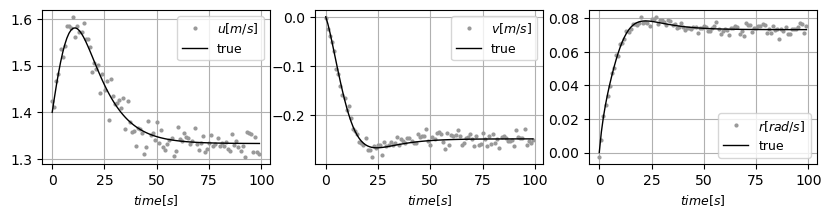

In [11]:
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1, 3, 1)
ax.plot(time_list[:], u_obs[:],label=L"u[m/s]", "o", c="0.6", markersize=2)
ax.plot(time_list[:], u[:], label="true", "-", c="k", linewidth=1)
ax.legend(frameon=true, fontsize=9)
ax.set_xlabel(L"time[s]", fontsize=9)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
ax.plot(time_list[:], v_obs[:],label=L"v[m/s]", "o", c="0.6", markersize=2)
ax.plot(time_list[:], v[:], label="true", "-", c="k", linewidth=1)
ax.legend(frameon=true, fontsize=9)
ax.set_xlabel(L"time[s]", fontsize=9)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
ax.plot(time_list[:], r_obs[:],label=L"r[rad/s]", "o", c="0.6", markersize=2)
ax.plot(time_list[:], r[:], label="true", "-", c="k", linewidth=1)
ax.legend(frameon=true, fontsize=9)
ax.set_xlabel(L"time[s]", fontsize=9)
ax.grid()
display(fig)

### 3.2 MCMCの実行

In [12]:
function MCMC()
# 事前分布＝一様分布の定義
    R_0_dash_under, R_0_dash_upper = 0.000, 0.100
    X_vv_dash_under, X_vv_dash_upper = -0.200, 0.200
    X_vr_dash_under, X_vr_dash_upper = -0.223, 0.177
    X_rr_dash_under, X_rr_dash_upper = -0.088, 0.032
    X_vvvv_dash_under, X_vvvv_dash_upper = -1.400, 1.400
    Y_v_dash_under, Y_v_dash_upper = -0.500, 0.000
    Y_r_dash_under, Y_r_dash_upper = -0.100, 0.200
    Y_vvv_dash_under, Y_vvv_dash_upper = -6.000, 2.000
    Y_vvr_dash_under, Y_vvr_dash_upper = -2.500, 1.000
    Y_vrr_dash_under, Y_vrr_dash_upper = -1.500, 0.000
    Y_rrr_dash_under, Y_rrr_dash_upper = -0.120, 0.040
    N_v_dash_under, N_v_dash_upper = -0.200, 0.000
    N_r_dash_under, N_r_dash_upper = -0.100, 0.000
    N_vvv_dash_under, N_vvv_dash_upper = -0.500, 0.400
    N_vvr_dash_under, N_vvr_dash_upper = -1.000, 0.000
    N_vrr_dash_under, N_vrr_dash_upper = -0.300, 0.300
    N_rrr_dash_under, N_rrr_dash_upper = -0.060, 0.000

    R_0_dash_prior_dist_setting = Uniform(R_0_dash_under, R_0_dash_upper)
    X_vv_dash_prior_dist_setting = Uniform(X_vv_dash_under, X_vv_dash_upper)
    X_vr_dash_prior_dist_setting = Uniform(X_vr_dash_under, X_vr_dash_upper)
    X_rr_dash_prior_dist_setting = Uniform(X_rr_dash_under, X_rr_dash_upper)
    X_vvvv_dash_prior_dist_setting = Uniform(X_vvvv_dash_under, X_vvvv_dash_upper)
    Y_v_dash_prior_dist_setting = Uniform(Y_v_dash_under, Y_v_dash_upper)
    Y_r_dash_prior_dist_setting = Uniform(Y_r_dash_under, Y_r_dash_upper)
    Y_vvv_dash_prior_dist_setting = Uniform(Y_vvv_dash_under, Y_vvv_dash_upper)
    Y_vvr_dash_prior_dist_setting = Uniform(Y_vvr_dash_under, Y_vvr_dash_upper)
    Y_vrr_dash_prior_dist_setting = Uniform(Y_vrr_dash_under, Y_vrr_dash_upper)
    Y_rrr_dash_prior_dist_setting = Uniform(Y_rrr_dash_under, Y_rrr_dash_upper)
    N_v_dash_prior_dist_setting = Uniform(N_v_dash_under, N_v_dash_upper)
    N_r_dash_prior_dist_setting = Uniform(N_r_dash_under, N_r_dash_upper)
    N_vvv_dash_prior_dist_setting = Uniform(N_vvv_dash_under, N_vvv_dash_upper)
    N_vvr_dash_prior_dist_setting = Uniform(N_vvr_dash_under, N_vvr_dash_upper)
    N_vrr_dash_prior_dist_setting = Uniform(N_vrr_dash_under, N_vrr_dash_upper)
    N_rrr_dash_prior_dist_setting = Uniform(N_rrr_dash_under, N_rrr_dash_upper)

    # MCMC探索に使う初期値
    start_vals = push!(rand(3)
                ,maneuvering_params.R_0_dash
                ,maneuvering_params.X_vv_dash
                ,maneuvering_params.X_vr_dash
                ,maneuvering_params.X_rr_dash
                ,maneuvering_params.X_vvvv_dash
                ,maneuvering_params.Y_v_dash
                ,maneuvering_params.Y_r_dash
                ,maneuvering_params.Y_vvv_dash
                ,maneuvering_params.Y_vvr_dash
                ,maneuvering_params.Y_vrr_dash
                ,maneuvering_params.Y_rrr_dash
                ,maneuvering_params.N_v_dash
                ,maneuvering_params.N_r_dash
                ,maneuvering_params.N_vvv_dash
                ,maneuvering_params.N_vvr_dash
                ,maneuvering_params.N_vrr_dash
                ,maneuvering_params.N_rrr_dash
                );

    # サンプリング回数
    sampling_n = 1000;

    # MCMCの実行
    model = []
    model = create_model_for_mcmc_sample_mmg(
            data,
            basic_params,
            maneuvering_params.k_0,
            maneuvering_params.k_1,
            maneuvering_params.k_2,
            ρ=1025.0,
            σ_u_prior_dist = Uniform(0.0, 1.0), #InverseGamma(1,1),
            σ_v_prior_dist = Uniform(0.0, 1.0), #InverseGamma(1,1),
            σ_r_prior_dist = Uniform(0.0, 1.0), #InverseGamma(1,1),
            R_0_dash_prior_dist = R_0_dash_prior_dist_setting,
            X_vv_dash_prior_dist = X_vv_dash_prior_dist_setting,
            X_vr_dash_prior_dist = X_vr_dash_prior_dist_setting,
            X_rr_dash_prior_dist = X_rr_dash_prior_dist_setting,
            X_vvvv_dash_prior_dist = X_vvvv_dash_prior_dist_setting,
            Y_v_dash_prior_dist = Y_v_dash_prior_dist_setting,
            Y_r_dash_prior_dist = Y_r_dash_prior_dist_setting,
            Y_vvv_dash_prior_dist = Y_vvv_dash_prior_dist_setting,
            Y_vvr_dash_prior_dist = Y_vvr_dash_prior_dist_setting,
            Y_vrr_dash_prior_dist = Y_vrr_dash_prior_dist_setting,
            Y_rrr_dash_prior_dist = Y_rrr_dash_prior_dist_setting,
            N_v_dash_prior_dist = N_v_dash_prior_dist_setting,
            N_r_dash_prior_dist = N_r_dash_prior_dist_setting,
            N_vvv_dash_prior_dist = N_vvv_dash_prior_dist_setting,
            N_vvr_dash_prior_dist = N_vvr_dash_prior_dist_setting,
            N_vrr_dash_prior_dist = N_vrr_dash_prior_dist_setting,
            N_rrr_dash_prior_dist = N_rrr_dash_prior_dist_setting,
        )

    chain = []
    chain = sample(model, NUTS(500, 0.65), sampling_n ; initial_params=start_vals)

    chain_array = Array(chain)
    coefficient_list = DataFrame(chain_array,[:sigma_u, :sigma_v, :sigma_r, :R_0, :X_vv, :X_vr, :X_rr, :X_vvvv, :Y_v, :Y_r, :Y_vvv, :Y_vvr, :Y_vrr, :Y_rrr, :N_v, :N_r, :N_vvv, :N_vvr, :N_vrr, :N_rrr])
    CSV.write("./result/10degL2MCMC_KVLCC2.csv", coefficient_list)
end

MCMC (generic function with 1 method)

In [13]:
Threads.nthreads()

6

In [14]:
MCMC()

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/hirukawa/.julia/packages/Turing/HwTAU/src/inference/hmc.jl:197
Sampling   0%|▎                                         |  ETA: 5:07:42
Sampling   1%|▍                                         |  ETA: 2:34:19
Sampling   1%|▋                                         |  ETA: 1:46:46
Sampling   2%|▊                                         |  ETA: 1:42:33
Sampling   2%|█                                         |  ETA: 1:38:49
Sampling   3%|█▏                                        |  ETA: 1:32:18
Sampling   3%|█▍                                        |  ETA: 1:29:26
Sampling   4%|█▋                                        |  ETA: 1:27:05
Sampling   4%|█▊                                        |  ETA: 1:26:51
Sampling   5%|██                                        |  ETA: 1:26:20
Sampling   5%|██▏                                       |  ETA: 1:25:55
Sampl

"./result/10degL2MCMC_KVLCC2.csv"

## 4.同定結果のシミュレーション

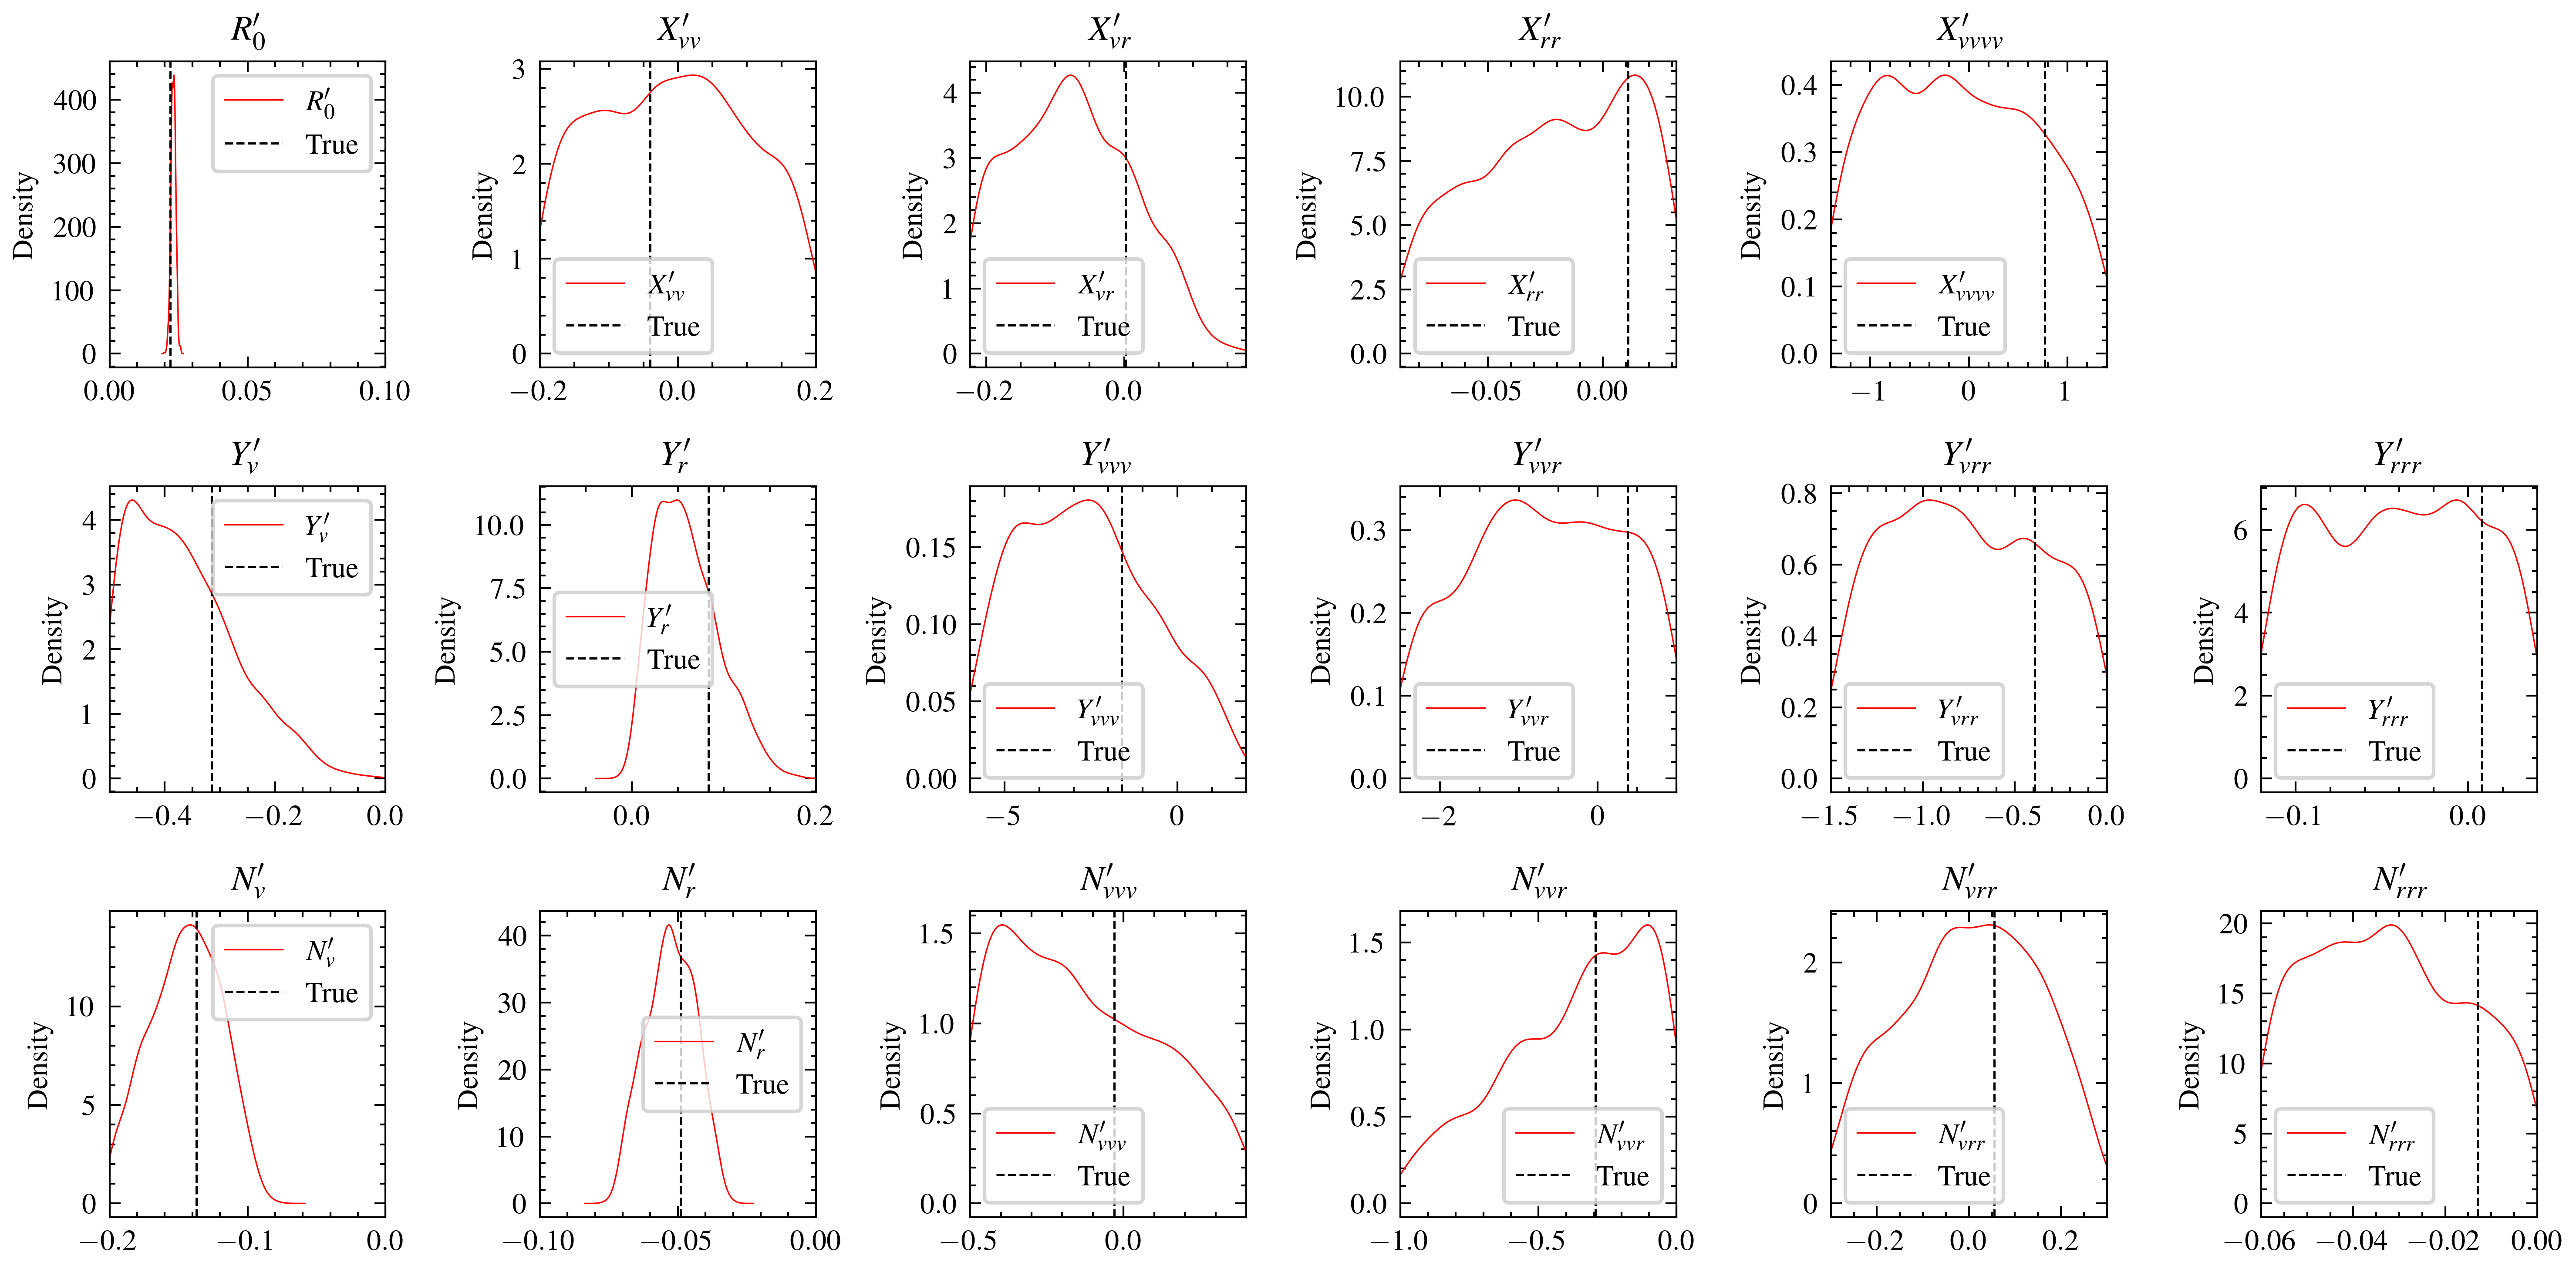

In [16]:
plt.style.use(["science", "ieee"])

# データの読み込み
data = CSV.read("./result/10degL2MCMC_KVLCC2.csv", DataFrame)
fig = plt.figure(figsize=(10, 5))
start_num = 1
end_num = 1000
# R_0_dash
R_0_posterior = data.R_0[start_num:end_num]
kde_result = kde(R_0_posterior)
ax = fig.add_subplot(3, 6, 1)
ax.plot(kde_result.x, kde_result.density, label=L"R_0^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.022, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"R_0^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(0.00, 0.10)

# X_vv_dash
X_vv_posterior = data.X_vv[start_num:end_num]
kde_result = kde(X_vv_posterior)
ax = fig.add_subplot(3, 6, 2)
ax.plot(kde_result.x, kde_result.density, label=L"X_{vv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.040, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{vv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.20, 0.20)

# X_vr_dash
X_vr_posterior = data.X_vr[start_num:end_num]
kde_result = kde(X_vr_posterior)
ax = fig.add_subplot(3, 6, 3)
ax.plot(kde_result.x, kde_result.density, label=L"X_{vr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.002, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{vr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.223, 0.177)

# X_rr_dash
X_rr_posterior = data.X_rr[start_num:end_num]
kde_result = kde(X_rr_posterior)
ax = fig.add_subplot(3, 6, 4)
ax.plot(kde_result.x, kde_result.density, label=L"X_{rr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.011, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{rr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.088, 0.032)

# X_vvvv_dash
X_vvvv_posterior = data.X_vvvv[start_num:end_num]
kde_result = kde(X_vvvv_posterior)
ax = fig.add_subplot(3, 6, 5)
ax.plot(kde_result.x, kde_result.density, label=L"X_{vvvv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.771, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{vvvv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-1.40, 1.40)

# Y_v_dash
Y_v_posterior = data.Y_v[start_num:end_num]
kde_result = kde(Y_v_posterior)
ax = fig.add_subplot(3, 6, 7)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{v}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.315, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{v}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.50, 0.00)

# Y_r_dash
Y_r_posterior = data.Y_r[start_num:end_num]
kde_result = kde(Y_r_posterior)
ax = fig.add_subplot(3, 6, 8)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{r}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.083, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{r}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.10, 0.20)

# Y_vvv_dash
Y_vvv_posterior = data.Y_vvv[start_num:end_num]
kde_result = kde(Y_vvv_posterior)
ax = fig.add_subplot(3, 6, 9)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{vvv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-1.607, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{vvv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-6.00, 2.00)

# Y_vvr_dash
Y_vvr_posterior = data.Y_vvr[start_num:end_num]
kde_result = kde(Y_vvr_posterior)
ax = fig.add_subplot(3, 6, 10)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{vvr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.379, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{vvr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-2.50, 1.00)

# Y_vrr_dash
Y_vrr_posterior = data.Y_vrr[start_num:end_num]
kde_result = kde(Y_vrr_posterior)
ax = fig.add_subplot(3, 6, 11)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{vrr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.391, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{vrr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-1.50, 0.00)

# Y_rrr_dash
Y_rrr_posterior = data.Y_rrr[start_num:end_num]
kde_result = kde(Y_rrr_posterior)
ax = fig.add_subplot(3, 6, 12)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{rrr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.008, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{rrr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.12, 0.04)

# N_v_dash
N_v_posterior = data.N_v[start_num:end_num]
kde_result = kde(N_v_posterior)
ax = fig.add_subplot(3, 6, 13)
ax.plot(kde_result.x, kde_result.density, label=L"N_{v}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.137, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{v}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.20, 0.00)

# N_r_dash
N_r_posterior = data.N_r[start_num:end_num]
kde_result = kde(N_r_posterior)
ax = fig.add_subplot(3, 6, 14)
ax.plot(kde_result.x, kde_result.density, label=L"N_{r}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.049, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{r}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.10, 0.00)

# N_vvv_dash 
N_vvv_posterior = data.N_vvv[start_num:end_num]
kde_result = kde(N_vvv_posterior) 
ax = fig.add_subplot(3, 6, 15) 
ax.plot(kde_result.x, kde_result.density, label=L"N_{vvv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.030, c="k", linestyle="--", label="True", linewidth=0.6) 
ax.set_ylabel(L"\textrm{Density}") 
ax.set_title(L"N_{vvv}^{\prime}") 
ax.legend(frameon=true) 
ax.set_xlim(-0.50, 0.40) 
# N_vvr_dash 
N_vvr_posterior = data.N_vvr[start_num:end_num]
kde_result = kde(N_vvr_posterior) 
ax = fig.add_subplot(3, 6, 16) 
ax.plot(kde_result.x, kde_result.density, label=L"N_{vvr}^{\prime}", c="r", linewidth=0.4) 
ax.axvline(x=-0.294, c="k", linestyle="--", label="True", linewidth=0.6) 
ax.set_ylabel(L"\textrm{Density}") 
ax.set_title(L"N_{vvr}^{\prime}") 
ax.legend(frameon=true) 
ax.set_xlim(-1.00, 0.00) 
# N_vrr_dash 
N_vrr_posterior = data.N_vrr[start_num:end_num]
kde_result = kde(N_vrr_posterior) 
ax = fig.add_subplot(3, 6, 17) 
ax.plot(kde_result.x, kde_result.density, label=L"N_{vrr}^{\prime}", c="r", linewidth=0.4) 
ax.axvline(x=0.055, c="k", linestyle="--", label="True", linewidth=0.6) 
ax.set_ylabel(L"\textrm{Density}") 
ax.set_title(L"N_{vrr}^{\prime}") 
ax.legend(frameon=true) 
ax.set_xlim(-0.30, 0.30)
# N_rrr_dash 
N_rrr_posterior = data.N_rrr[start_num:end_num]
kde_result = kde(N_rrr_posterior) 
ax = fig.add_subplot(3, 6, 18) 
ax.plot(kde_result.x, kde_result.density, label=L"N_{rrr}^{\prime}", c="r", linewidth=0.4) 
ax.axvline(x=-0.013, c="k", linestyle="--", label="True", linewidth=0.6) 
ax.set_ylabel(L"\textrm{Density}") 
ax.set_title(L"N_{rrr}^{\prime}") 
ax.legend(frameon=true) 
ax.set_xlim(-0.06, 0.00) 
plt.tight_layout() 
display(fig)